In [3]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import time
from bs4 import BeautifulSoup

from nba_headers import *

In [2]:
def write_nba_data(data, filename):
    from pathlib import Path
    
    filepath = Path("/Users/fordhiggins/basketball/analytics/data/")
    with open(filepath/filename, 'w') as outfile:
        wr = csv.writer(outfile, quoting = csv.QUOTE_ALL)
        wr.writerows(data)

In [4]:
base_url = "http://stats.nba.com/stats/leaguedashteamstats"

In [41]:
r = requests.get(base_url, headers = nba_headers, params = team_params)

In [43]:
def scrape_nba_stats(base_url, headers, params, year_start=2017, year_end = 2017):
    data = list()
    
    for season in np.arange(year_start, year_end+1):
        params['Season'] = f'{season}-{str(season+1)[-2:]}'
#         print(params['Season'])
        time.sleep(np.random.randint(1, 4))
        r = requests.get(base_url, headers=headers, params=params)
        data_rows = r.json()['resultSets'][0]['rowSet']
        [row.insert(0, season+1) for row in data_rows]
        data.extend(data_rows)
#         [row.insert(0, season+1) for row in data] # change to 2016-17 from 2017?
    
    columns = [s.title() for s in r.json()['resultSets'][0]['headers']] # or lowercase or uppercase?
    columns.insert(0, 'Season')
    data.insert(0, columns)
    
    return data

In [44]:
data = scrape_nba_stats(base_url=base_url, headers=nba_headers, params=team_params, year_start=1996, year_end=2017)

In [37]:
write_nba_data(data, 'nba_tadv.csv')

In [4]:
df = pd.read_csv('../data/nba_tadv.csv')

In [41]:
df.head()

,Season,Team_Id,Team_Name,Gp,W,L,W_Pct,Min,Off_Rating,Def_Rating,...,Oreb_Pct_Rank,Dreb_Pct_Rank,Reb_Pct_Rank,Tm_Tov_Pct_Rank,Efg_Pct_Rank,Ts_Pct_Rank,Pace_Rank,Pie_Rank,Cfid,Cfparams
0,1997,1610612737,Atlanta Hawks,82,56,26,0.683,4076.0,105.4,98.9,...,10,14,8,13,12,12,27,4,10,Atlanta Hawks
1,1997,1610612738,Boston Celtics,82,15,67,0.183,4111.0,100.8,108.8,...,21,18,28,8,24,24,2,28,10,Boston Celtics
2,1997,1610612766,Charlotte Hornets,82,54,28,0.659,4086.0,108.0,105.6,...,26,22,22,5,3,2,21,10,10,Charlotte Hornets
3,1997,1610612741,Chicago Bulls,82,69,13,0.841,4069.0,111.1,99.2,...,2,12,2,2,5,7,15,2,10,Chicago Bulls
4,1997,1610612739,Cleveland Cavaliers,82,42,40,0.512,4115.0,102.0,99.4,...,22,3,10,16,15,18,29,13,10,Cleveland Cavaliers


In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
df_new = df.loc[:, ['W_Pct', 'Off_Rating_Rank', 'Def_Rating_Rank']].copy()

In [7]:
df_new.head()

,W_Pct,Off_Rating_Rank,Def_Rating_Rank
0,0.683,8,3
1,0.183,26,27
2,0.659,4,19
3,0.841,1,4
4,0.512,19,5


In [8]:
lr = LinearRegression()

In [9]:
X = df_new.drop('W_Pct', axis = 1)
y = df_new.W_Pct

lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
pred_w_pct = lr.predict(X)
df_new['pred_w_pct'] = pred_w_pct
df_new['pred_wins'] = np.round(82*pred_w_pct, 1)

In [11]:
lr.predict(np.array([8, 3]).reshape(1, -1))*82

array([58.40568054])

In [12]:
df_new.head()

,W_Pct,Off_Rating_Rank,Def_Rating_Rank,pred_w_pct,pred_wins
0,0.683,8,3,0.712264,58.4
1,0.183,26,27,0.257313,21.1
2,0.659,4,19,0.586692,48.1
3,0.841,1,4,0.779395,63.9
4,0.512,19,5,0.568825,46.6


In [13]:
def pred_wins_by_rating_ranks(pred_o_rating, pred_d_rating, model, wins = True):
    rank_array = np.array([pred_o_rating, pred_d_rating]).reshape(1, -1)
    pred = model.predict(rank_array)
    return np.round(82*pred, 1) if wins else np.round(pred, 1)

# any way to use previous function in here?
# make another function for training the model?
def pred_wins_by_rating_rank_grid(model, wins = True):
    from itertools import product
    ranking_grid = [x for x in product(np.arange(1, 31), np.arange(1, 31))]
    preds = np.round(82*model.predict(ranking_grid), 1) if wins else np.round(model.predict(ranking_grid), 1)
    df = pd.DataFrame(ranking_grid, columns=['Off_Rating_Rank', 'Def_Rating_Rank'])
    df['Preds'] = preds
    return df

In [14]:
ranking_wins_df = pred_wins_by_rating_rank_grid(lr)

In [13]:
wins_matrix = [(ranking_wins_df.Off_Rating_Rank.values, ranking_wins_df.Def_Rating_Rank.values),
               ranking_wins_df.Preds.values]

In [15]:
ranking_wins_df.head()

,Off_Rating_Rank,Def_Rating_Rank,Preds
0,1,1,66.5
1,1,2,65.7
2,1,3,64.8
3,1,4,63.9
4,1,5,63.0


In [16]:
ranking_wins_df.to_csv('../results/tables/rating_rank_preds_2018.csv')

In [4]:
ranking_wins_df = pd.read_csv('../results/tables/rating_rank_preds_2018.csv')

In [15]:
pred_wins_by_rating_ranks(9, 13, lr)

array([48.8])

In [5]:
import altair as alt
from altair.expr import datum

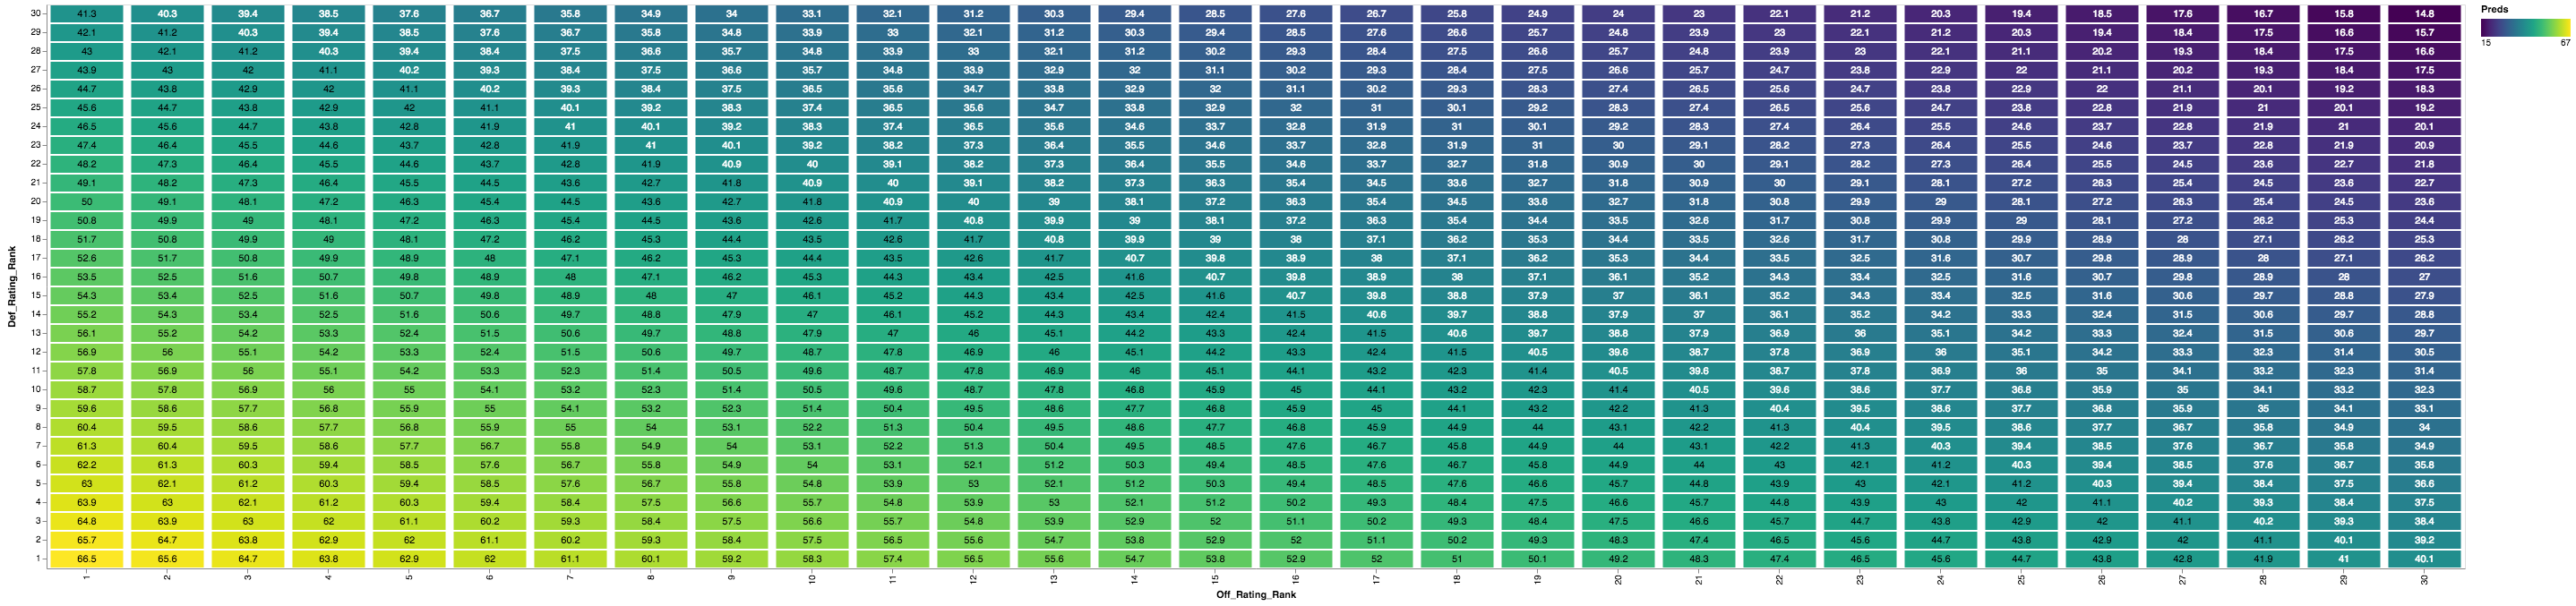

In [6]:
graph = alt.Chart(ranking_wins_df).mark_rect().encode(
    x='Off_Rating_Rank:O',
    y=alt.Y('Def_Rating_Rank:O', scale=alt.Scale(domain=[x for x in np.arange(30, 0, -1)])),
    color='Preds:Q'
)

# text = alt.Chart(cars).mark_text(baseline='middle').encode(
#     x='Cylinders:O',
#     y='Origin:O',
#     text='count()',
#     color=alt.condition(datum['count_*'] > 100,
#                         alt.value('black'),
#                         alt.value('white'))
# )

text = alt.Chart(ranking_wins_df).mark_text(baseline='middle').encode(
    x='Off_Rating_Rank:O',
    y=alt.Y('Def_Rating_Rank:O', scale=alt.Scale(domain=[x for x in np.arange(30, 0, -1)])),
    text='Preds:Q',
    color = alt.condition(datum.Preds > 41,
                         alt.value('black'),
                         alt.value('white'))
)

graph + text

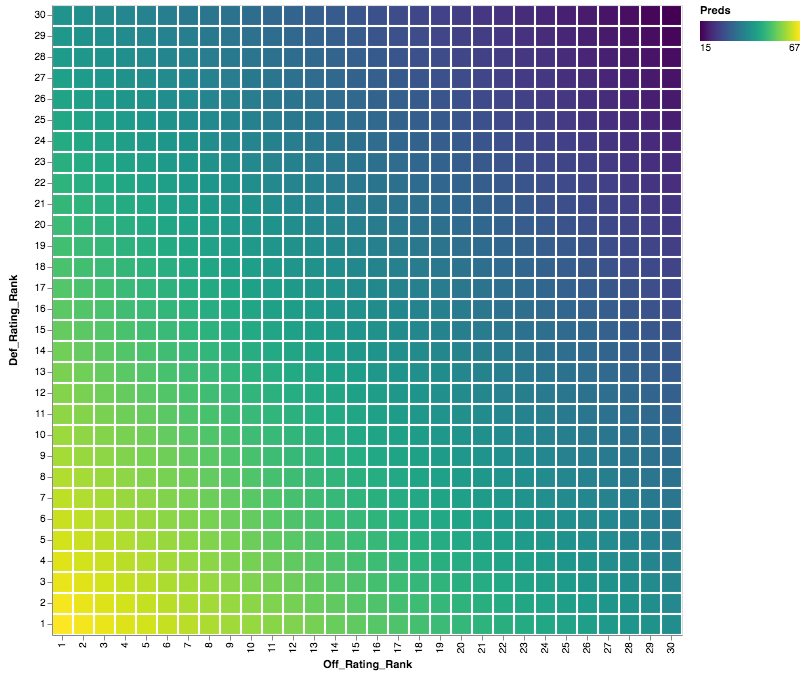

In [7]:
graph

In [160]:
pred_wins_by_rating_ranks(9, 16, lr)

array([46.2])

In [17]:
import plotly.plotly as py
import plotly.graph_objs as go

In [18]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [21]:
trace = go.Heatmap(x = ranking_wins_df.Off_Rating_Rank.values,
                   y = ranking_wins_df.Def_Rating_Rank.values,
                   z = ranking_wins_df.Preds.values)
data = [trace]
iplot(data, filename = 'heatmap')